In [2]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
%matplotlib inline

In [3]:
from IPython.display import HTML
style = "<style>svg{width:70% !important; height:70% !important;}</style>"
HTML(style)

In [4]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#тюнит параметры с помощью кросс-валидации
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

,name,date,value
region,,,
Russia,The number of applications for consumer loans,2013-01-15,571147
Russia,The number of applications for consumer loans,2013-02-15,504508
Russia,The number of applications for consumer loans,2013-03-15,628803
Russia,The number of applications for consumer loans,2013-04-15,836054
Russia,The number of applications for consumer loans,2013-05-15,867235


In [5]:
data = pd.read_csv("~/data/df.csv", index_col="region", parse_dates=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74842 entries, Russia to Yaroslavskaya oblast
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    74842 non-null  object
 1   date    74842 non-null  object
 2   value   74842 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [9]:
data.describe()

,value
count,7.484200e+04
mean,2.018732e+05
std,4.527957e+05
min,1.000000e+00
25%,1.412000e+03
50%,1.395050e+04
75%,1.992958e+05
max,6.631650e+06


In [7]:
data.shape

(74842, 3)

In [6]:
data["name"].unique()

array(['The number of applications for consumer loans',
       'Average consumer loan application',
       'The number of applications for mortgages',
       'The average amount of a mortgage application',
       'Number of new deposits', 'Average amount of new deposit',
       'Average salary', 'Average pension',
       'On average rubles on current account per person',
       'On average, deposits in rubles per person',
       'Average spending on cards', 'Average Fast Food format Check',
       'Average check in Restaurant format',
       'Average spending in a fast food restaurant',
       'Average spending in a restaurant'], dtype=object)

In [9]:
data

,name,date,value
region,,,
Russia,The number of applications for consumer loans,2013-01-15,571147
Russia,The number of applications for consumer loans,2013-02-15,504508
Russia,The number of applications for consumer loans,2013-03-15,628803
Russia,The number of applications for consumer loans,2013-04-15,836054
Russia,The number of applications for consumer loans,2013-05-15,867235
...,...,...,...
Yaroslavskaya oblast,Average spending in a restaurant,2018-07-15,1274
Yaroslavskaya oblast,Average spending in a restaurant,2018-08-15,1263
Yaroslavskaya oblast,Average spending in a restaurant,2018-09-15,1184


In [22]:
new.head()

name,region,date,Average Fast Food format Check,Average amount of new deposit,Average check in Restaurant format,Average consumer loan application,Average pension,Average salary,Average spending in a fast food restaurant,Average spending in a restaurant,Average spending on cards,Number of new deposits,On average rubles on current account per person,"On average, deposits in rubles per person",The average amount of a mortgage application,The number of applications for consumer loans,The number of applications for mortgages
0,Altai region,2013-01-15,0,0,0,133509,0,0,0,0,0,0,0,0,968154,13423,508
1,Altai region,2013-02-15,0,0,0,150030,0,0,0,0,0,0,0,0,957201,12440,641
2,Altai region,2013-03-15,0,0,0,151795,0,0,0,0,0,0,0,0,974481,15906,853
3,Altai region,2013-04-15,0,0,0,148752,0,0,0,0,0,0,0,0,985195,22172,1072
4,Altai region,2013-05-15,0,0,0,150903,0,0,0,0,0,0,0,0,955750,22642,807


In [6]:
new = data.pivot_table(index=["region", "date"], columns="name", values="value", aggfunc="mean", fill_value=0).reset_index()

In [13]:
new.describe()

name,Average Fast Food format Check,Average amount of new deposit,Average check in Restaurant format,Average consumer loan application,Average pension,Average salary,Average spending in a fast food restaurant,Average spending in a restaurant,Average spending on cards,Number of new deposits,On average rubles on current account per person,"On average, deposits in rubles per person",The average amount of a mortgage application,The number of applications for consumer loans,The number of applications for mortgages
count,6132.000000,6.132000e+03,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6.132000e+03,6132.000000,6.132000e+03,6.132000e+03,6.132000e+03,6132.000000
mean,217.309361,2.347876e+05,380.931670,230029.326647,11926.290770,19553.695042,613.514025,998.156556,7458.347847,3.745632e+04,17084.223092,3.378201e+05,1.541666e+06,2.143624e+04,2464.977332
std,168.651108,2.053471e+05,321.926864,71376.895421,6548.561829,17544.850796,494.643900,826.886805,5165.053964,2.019944e+05,12471.079767,2.632673e+05,4.788155e+05,1.040387e+05,11856.415242
min,0.000000,0.000000e+00,0.000000,116468.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,0.000000
25%,0.000000,1.611165e+05,0.000000,183257.750000,10321.000000,0.000000,0.000000,0.000000,4417.750000,1.232500e+03,11804.500000,2.347342e+05,1.217118e+06,4.148500e+03,377.000000
50%,295.000000,2.276035e+05,442.500000,210423.500000,12943.000000,21038.000000,767.000000,1210.000000,7184.500000,1.224550e+04,15980.000000,3.191910e+05,1.406126e+06,7.772000e+03,773.000000
75%,341.000000,3.051988e+05,608.250000,251209.250000,15044.250000,28039.250000,976.000000,1578.250000,10107.500000,2.545900e+04,20914.500000,4.138628e+05,1.705787e+06,1.403900e+04,1564.000000
max,597.000000,6.631650e+06,1646.000000,875000.000000,88132.000000,123204.000000,2298.000000,3508.000000,30273.000000,4.732173e+06,87712.000000,2.093545e+06,4.600000e+06,2.175857e+06,182146.000000


In [14]:
new.loc[0:5, 'Average salary']

0    0
1    0
2    0
3    0
4    0
5    0
Name: Average salary, dtype: int64

In [15]:
new.iloc[:, 2:4]

name,Average Fast Food format Check,Average amount of new deposit
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
6127,304,300536
6128,290,339212
6129,300,396653
6130,0,0


In [24]:
new.groupby("region")[["Average salary", "The number of applications for consumer loans"]].agg(np.mean)

name,Average salary,The number of applications for consumer loans
region,,
Altai region,12521.136986,17834.054795
Amur region,21239.534247,6017.082192
Arhangelsk region,22617.684932,9555.863014
Astrakhan region,15411.561644,7797.972603
Belgorod region,15722.767123,13365.356164
...,...,...
Volgograd region,14482.369863,13235.821918
Vologda Region,15917.671233,8264.232877
Voronezh region,15581.054795,13770.315068


In [7]:
new.head()

name,region,date,Average Fast Food format Check,Average amount of new deposit,Average check in Restaurant format,Average consumer loan application,Average pension,Average salary,Average spending in a fast food restaurant,Average spending in a restaurant,Average spending on cards,Number of new deposits,On average rubles on current account per person,"On average, deposits in rubles per person",The average amount of a mortgage application,The number of applications for consumer loans,The number of applications for mortgages
0,Altai region,2013-01-15,0,0,0,133509,0,0,0,0,0,0,0,0,968154,13423,508
1,Altai region,2013-02-15,0,0,0,150030,0,0,0,0,0,0,0,0,957201,12440,641
2,Altai region,2013-03-15,0,0,0,151795,0,0,0,0,0,0,0,0,974481,15906,853
3,Altai region,2013-04-15,0,0,0,148752,0,0,0,0,0,0,0,0,985195,22172,1072
4,Altai region,2013-05-15,0,0,0,150903,0,0,0,0,0,0,0,0,955750,22642,807


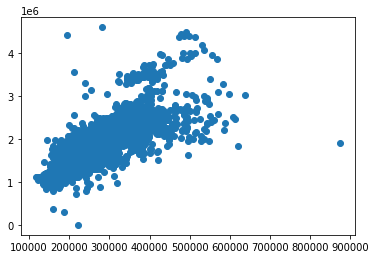

In [10]:
plt.scatter(new["Average consumer loan application"], new["The average amount of a mortgage application"])

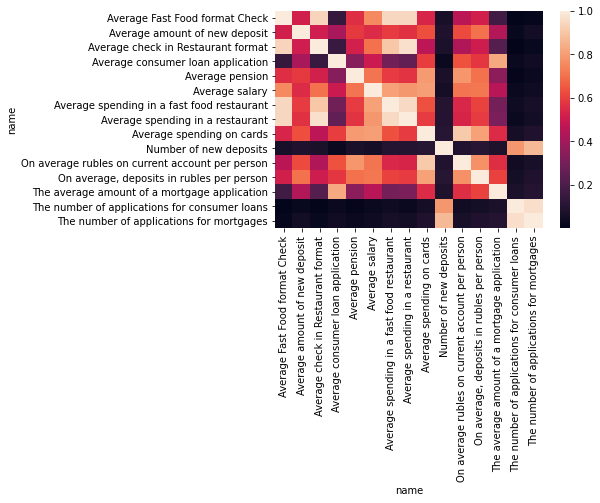

In [12]:
sns.heatmap(new.corr());

In [18]:
new[new['Average salary'] != 0]['Average salary'].mean()

29131.015063168124

In [19]:
new['Average salary'].mean()

19553.695042400523

In [12]:
new

name,region,date,Average Fast Food format Check,Average amount of new deposit,Average check in Restaurant format,Average consumer loan application,Average pension,Average salary,Average spending in a fast food restaurant,Average spending in a restaurant,Average spending on cards,Number of new deposits,On average rubles on current account per person,"On average, deposits in rubles per person",The average amount of a mortgage application,The number of applications for consumer loans,The number of applications for mortgages
0,Altai region,2013-01-15,0,0,0,133509,0,0,0,0,0,0,0,0,968154,13423,508
1,Altai region,2013-02-15,0,0,0,150030,0,0,0,0,0,0,0,0,957201,12440,641
2,Altai region,2013-03-15,0,0,0,151795,0,0,0,0,0,0,0,0,974481,15906,853
3,Altai region,2013-04-15,0,0,0,148752,0,0,0,0,0,0,0,0,985195,22172,1072
4,Altai region,2013-05-15,0,0,0,150903,0,0,0,0,0,0,0,0,955750,22642,807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6127,Yaroslavskaya oblast,2018-09-15,304,300536,415,213774,13654,28038,1183,1184,10148,18090,20912,484711,1478523,13134,1063
6128,Yaroslavskaya oblast,2018-10-15,290,339212,388,191267,15245,28616,1180,1181,10971,31566,21420,486868,1508535,8899,1221
6129,Yaroslavskaya oblast,2018-11-15,300,396653,402,209374,14462,28333,1180,1184,10607,56433,20151,488599,1530875,4412,1329
6130,Yaroslavskaya oblast,2018-12-15,0,0,0,207884,24341,39245,0,0,12031,0,22936,494112,1506392,8249,1237


In [11]:
new = new.reset_index()

In [12]:
new.isnull().sum()

name
index                                              0
region                                             0
date                                               0
Average Fast Food format Check                     0
Average amount of new deposit                      0
Average check in Restaurant format                 0
Average consumer loan application                  0
Average pension                                    0
Average salary                                     0
Average spending in a fast food restaurant         0
Average spending in a restaurant                   0
Average spending on cards                          0
Number of new deposits                             0
On average rubles on current account per person    0
On average, deposits in rubles per person          0
The average amount of a mortgage application       0
The number of applications for consumer loans      0
The number of applications for mortgages           0
dtype: int64

In [73]:
new

name,region,date,Average Fast Food format Check,Average amount of new deposit,Average check in Restaurant format,Average consumer loan application,Average pension,Average salary,Average spending in a fast food restaurant,Average spending in a restaurant,Average spending on cards,Number of new deposits,On average rubles on current account per person,"On average, deposits in rubles per person",The average amount of a mortgage application,The number of applications for consumer loans,The number of applications for mortgages
0,Altai region,2013-01-15,0,0,0,133509,0,0,0,0,0,0,0,0,968154,13423,508
1,Altai region,2013-02-15,0,0,0,150030,0,0,0,0,0,0,0,0,957201,12440,641
2,Altai region,2013-03-15,0,0,0,151795,0,0,0,0,0,0,0,0,974481,15906,853
3,Altai region,2013-04-15,0,0,0,148752,0,0,0,0,0,0,0,0,985195,22172,1072
4,Altai region,2013-05-15,0,0,0,150903,0,0,0,0,0,0,0,0,955750,22642,807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6054,Yaroslavskaya oblast,2018-09-15,304,300536,415,213774,13654,28038,1183,1184,10148,18090,20912,484711,1478523,13134,1063
6055,Yaroslavskaya oblast,2018-10-15,290,339212,388,191267,15245,28616,1180,1181,10971,31566,21420,486868,1508535,8899,1221
6056,Yaroslavskaya oblast,2018-11-15,300,396653,402,209374,14462,28333,1180,1184,10607,56433,20151,488599,1530875,4412,1329
6057,Yaroslavskaya oblast,2018-12-15,0,0,0,207884,24341,39245,0,0,12031,0,22936,494112,1506392,8249,1237


In [126]:
k = {}
for nval in new:
    for value in new[nval]:
        if(value == 0):
            nval = nval.replace(" ", "")
            k[nval] = 1 if nval not in k else k[nval] + 1
print(k)

{'AverageFastFoodformatCheck': 2158, 'Averageamountofnewdeposit': 1162, 'AveragecheckinRestaurantformat': 2158, 'Averagepension': 996, 'Averagesalary': 1992, 'Averagespendinginafastfoodrestaurant': 2158, 'Averagespendinginarestaurant': 2158, 'Averagespendingoncards': 996, 'Numberofnewdeposits': 1162, 'Onaveragerublesoncurrentaccountperperson': 996, 'Onaverage,depositsinrublesperperson': 996, 'Theaverageamountofamortgageapplication': 1, 'Thenumberofapplicationsformortgages': 1}


In [128]:
#попробуем поресёчить данные без столбцов, по которым мало данных

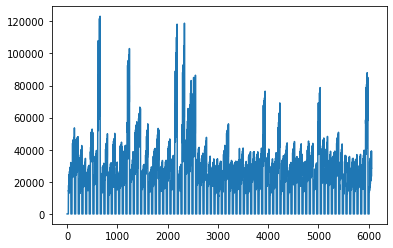

In [649]:
new["Average salary"].plot()

In [140]:
df_mean_by_region = new.groupby(["region"]).mean()

In [157]:
mean_without_index = df_mean_by_region.reset_index()

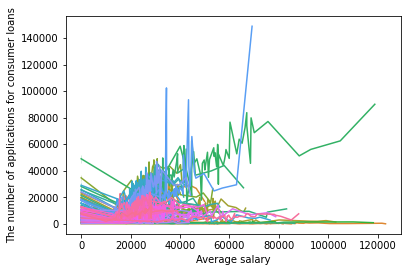

In [188]:
sns.lineplot(x="Average salary", y="The number of applications for consumer loans", hue="region", data = new, legend=False)

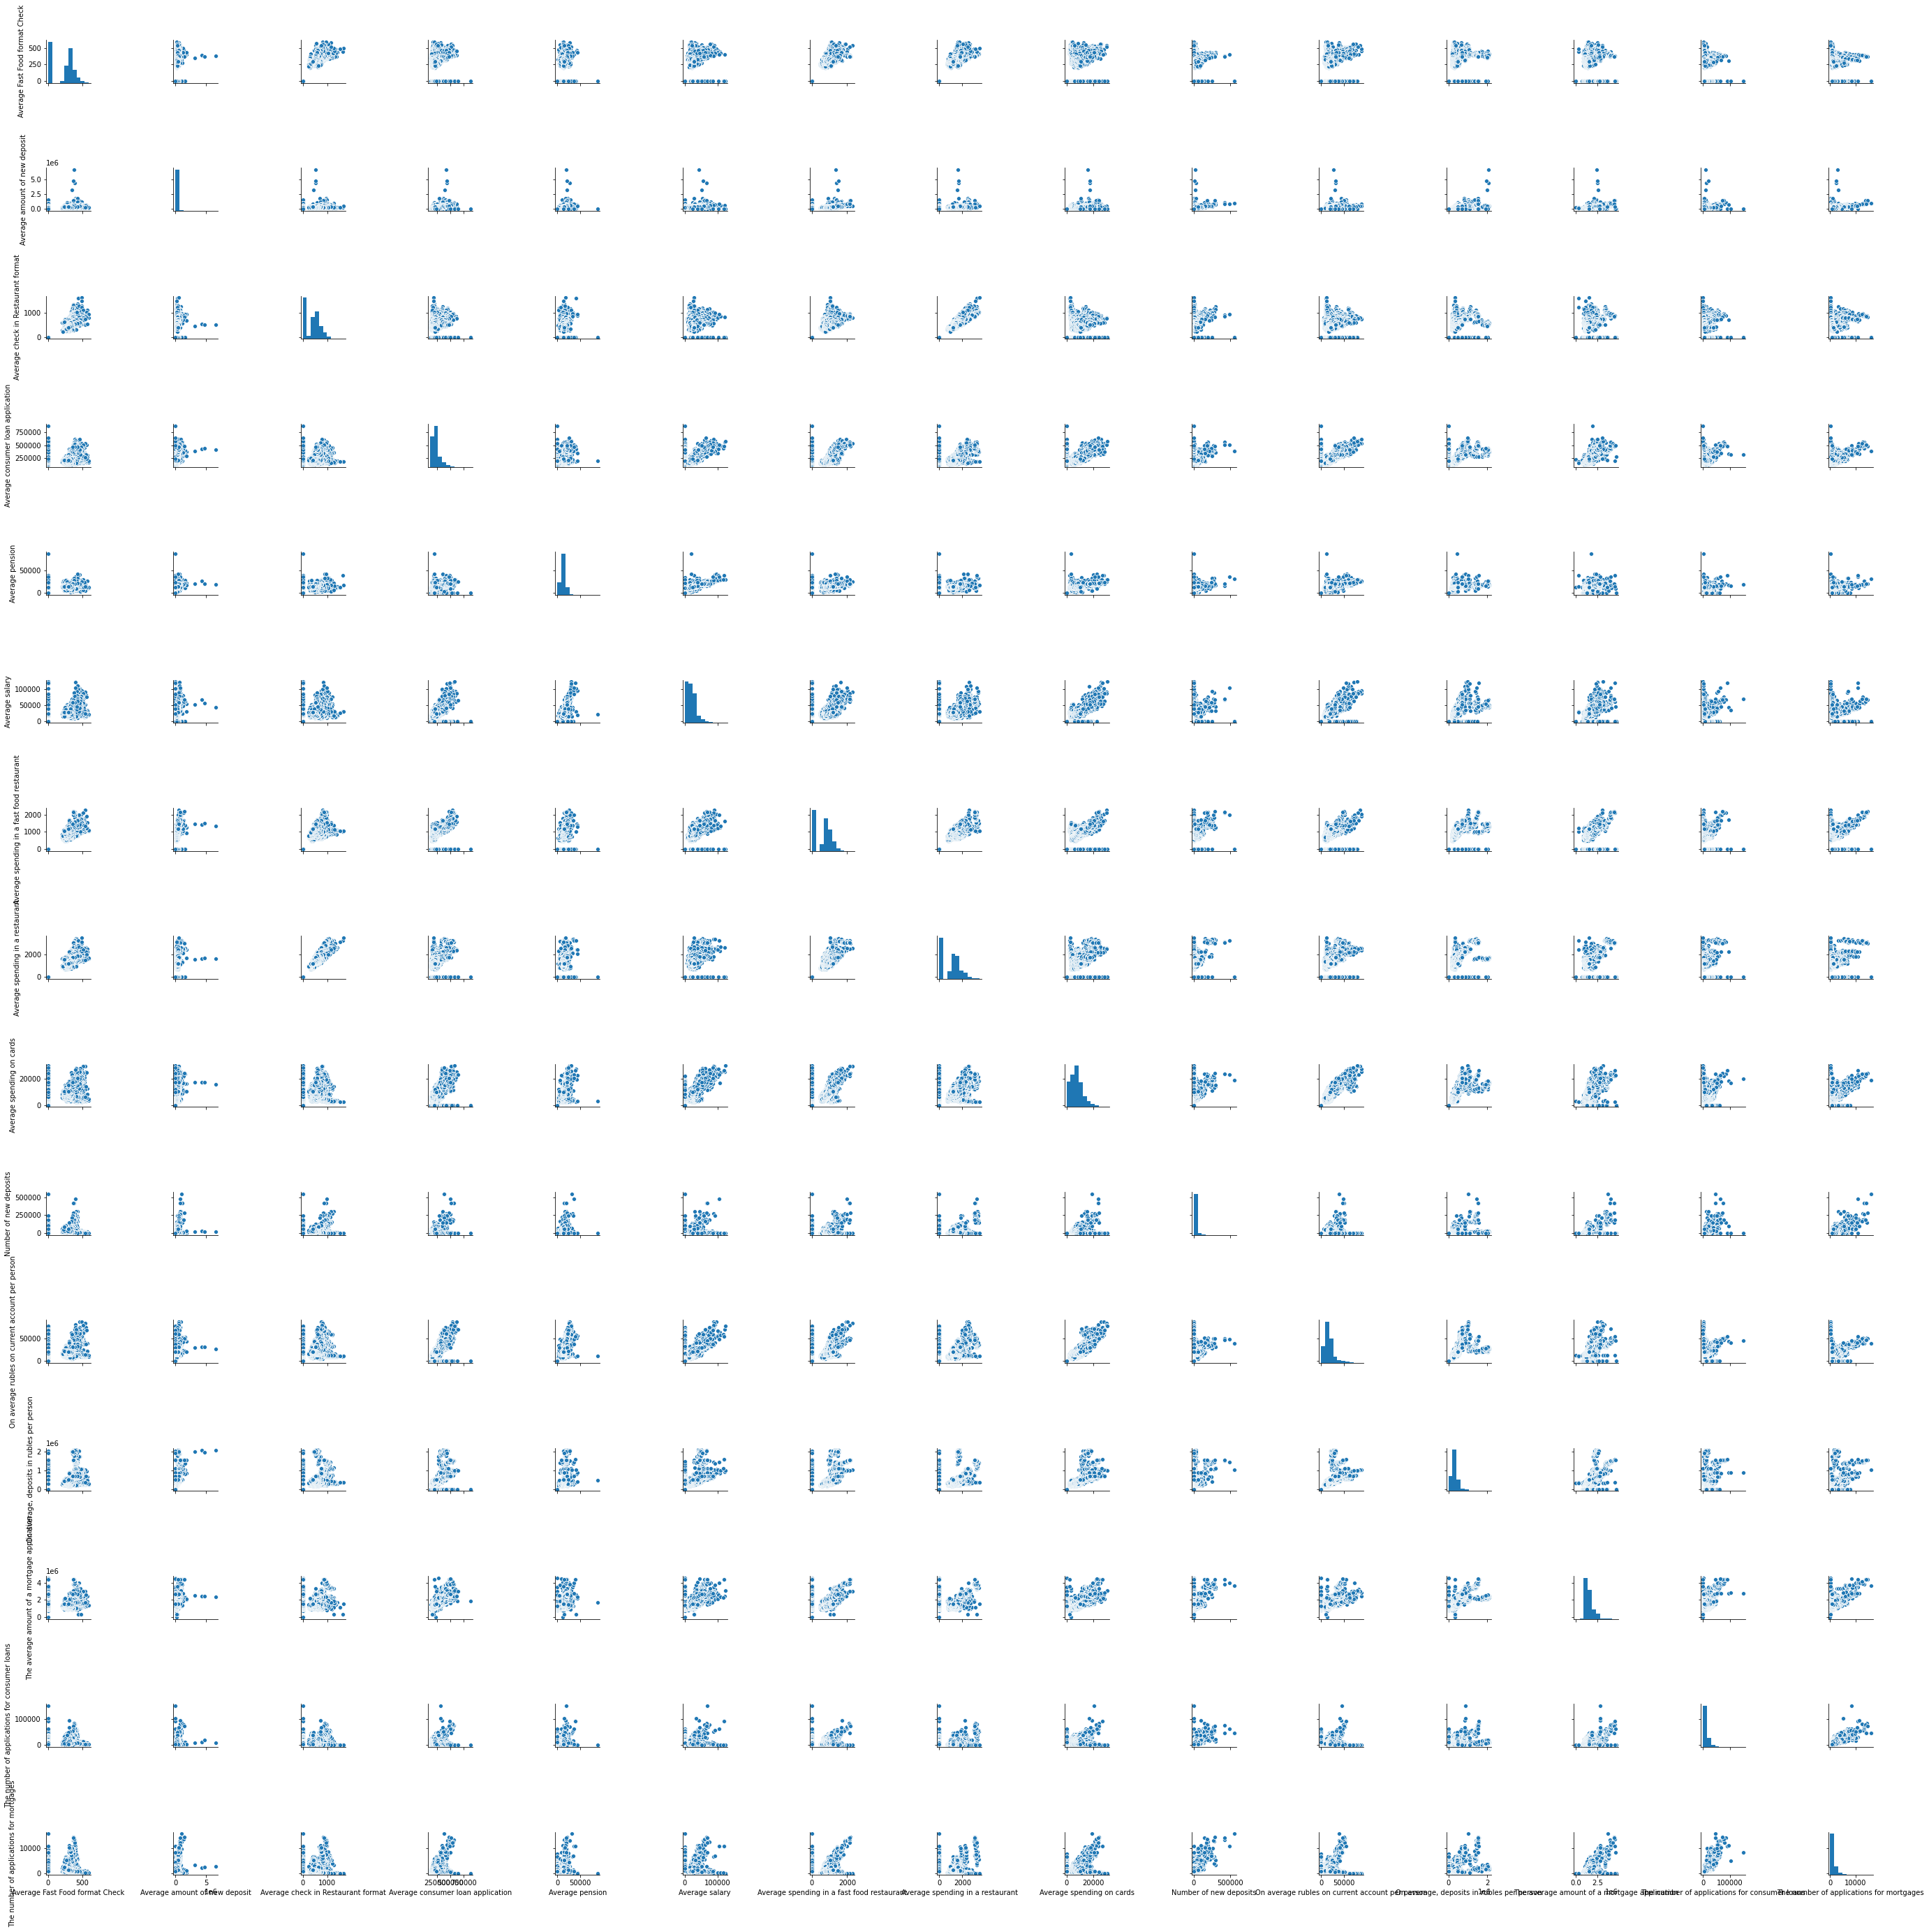

In [267]:
sns.pairplot(new)

In [181]:
new[new["region"] == "Moscow"]

name,region,date,Average Fast Food format Check,Average amount of new deposit,Average check in Restaurant format,Average consumer loan application,Average pension,Average salary,Average spending in a fast food restaurant,Average spending in a restaurant,Average spending on cards,Number of new deposits,On average rubles on current account per person,"On average, deposits in rubles per person",The average amount of a mortgage application,The number of applications for consumer loans,The number of applications for mortgages
2263,Moscow,2013-01-15,0,0,0,365863,0,0,0,0,0,0,0,0,3366996,32846,2672
2264,Moscow,2013-02-15,0,0,0,406069,0,0,0,0,0,0,0,0,3370182,28989,3164
2265,Moscow,2013-03-15,0,0,0,398799,0,0,0,0,0,0,0,0,3436360,38172,5972
2266,Moscow,2013-04-15,0,0,0,406440,0,0,0,0,0,0,0,0,3412007,50339,6634
2267,Moscow,2013-05-15,0,0,0,396806,0,0,0,0,0,0,0,0,3439656,53078,5748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,Moscow,2018-09-15,381,1395838,899,486850,18686,60242,2123,3053,22275,186568,47911,1533417,4406704,76760,13789
2332,Moscow,2018-10-15,369,1444640,847,474542,20448,66330,2186,3041,24375,287886,49881,1533150,4370595,72570,14654
2333,Moscow,2018-11-15,375,818037,871,513254,20089,68536,2143,3055,23805,424011,47244,1534478,4383000,45724,14180
2334,Moscow,2018-12-15,0,0,0,479241,39592,118870,0,0,26901,0,54628,1569338,4447537,90241,10878


In [14]:
without_moskow = new[(new["region"] != "Moscow") & (new["region"] != "Moscow region") & (new["region"] != "St. Petersburg")]

In [565]:
without_moskow=0

In [277]:
sns.lineplot(x="Average salary", y=["The number of applications for consumer loans", "Average amount of new deposit"], hue="region", data = without_moskow, legend=False)

AttributeError: module 'seaborn' has no attribute 'plot'

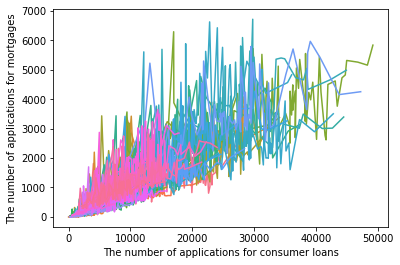

In [284]:
sns.lineplot(x="The number of applications for consumer loans", y="The number of applications for mortgages", hue="region", data = without_moskow, legend=False)

In [370]:
X = without_moskow.drop(["The number of applications for consumer loans", "region", "date"], axis=1)
y = without_moskow["The number of applications for consumer loans"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [374]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=100, min_samples_leaf=10)

In [375]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=10,
                       min_samples_split=100)

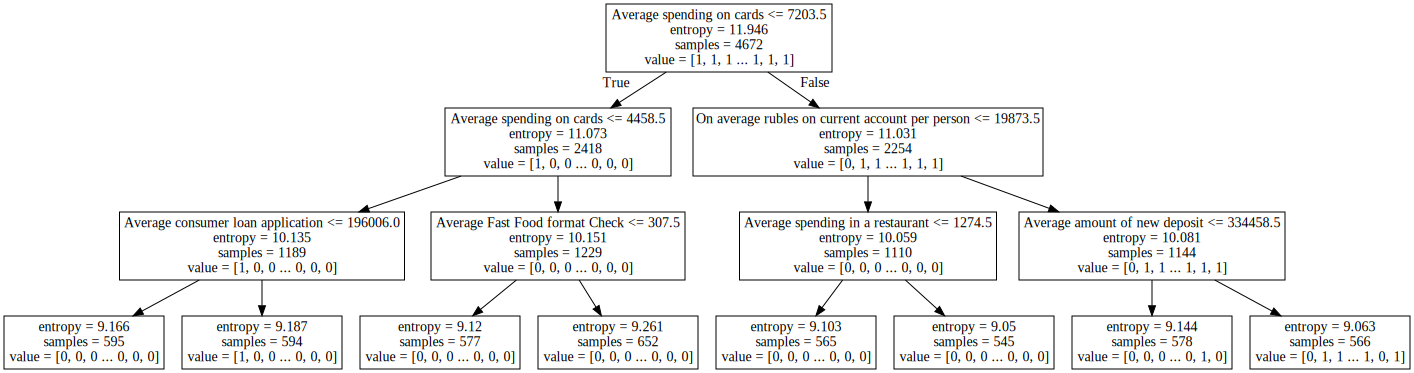

In [261]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(X_train)))
display(SVG(graph.pipe(format='svg')))

In [363]:

new_X = without_moskow.drop(["The number of applications for consumer loans", "region", "date"], axis=1)
new_y = without_moskow["The number of applications for consumer loans"]
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.33, random_state=42)

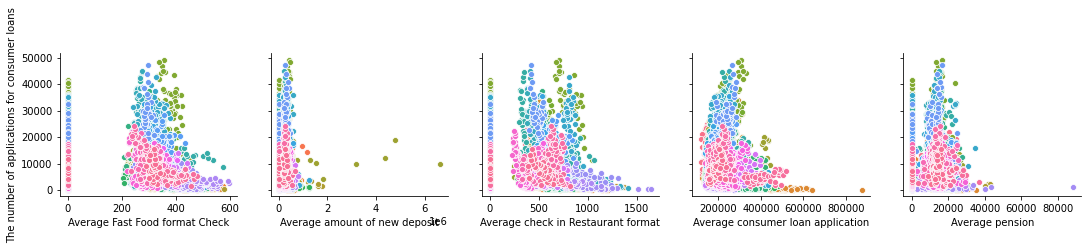

In [307]:
sns.pairplot(data=without_moskow, hue="region", x_vars=["Average Fast Food format Check", "Average amount of new deposit", "Average check in Restaurant format", "Average consumer loan application", "Average pension"], y_vars=["The number of applications for consumer loans"], height=3)._legend.remove()

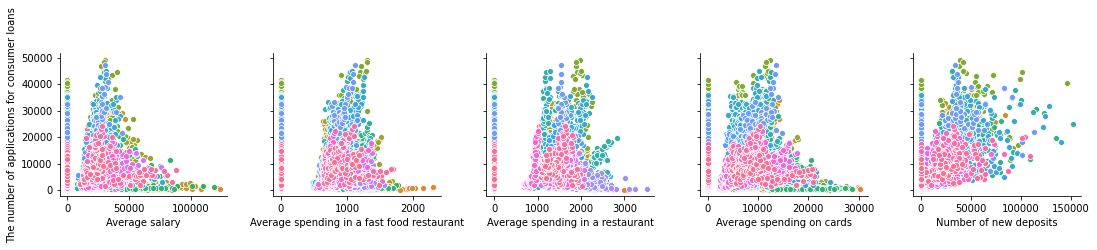

In [308]:
sns.pairplot(data=without_moskow, hue="region", x_vars=["Average salary", "Average spending in a fast food restaurant", "Average spending in a restaurant", "Average spending on cards", "Number of new deposits"], y_vars=["The number of applications for consumer loans"], height=3)._legend.remove()

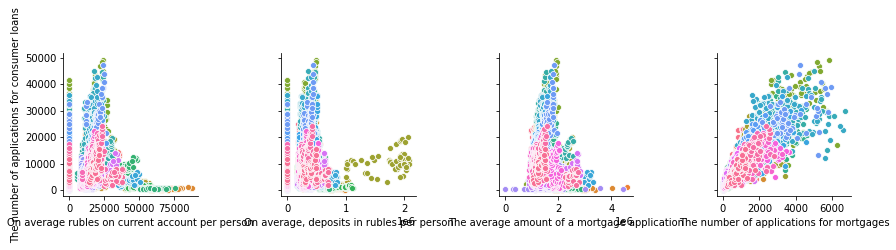

In [309]:
sns.pairplot(data=without_moskow, hue="region", x_vars=["On average rubles on current account per person", "On average, deposits in rubles per person", "The average amount of a mortgage application", "The number of applications for mortgages"], y_vars=["The number of applications for consumer loans"], height=3)._legend.remove()

In [311]:
#из графиков видно, что выраженную линейную зависимость с предсказываемой переменной имеют столбцы
#"Number of new deposits", "The number of applications for mortgages", "Average spending on cards"
#нужно ли их удалять??

In [312]:
#сначала сделаем рэндом форест по всем столбцам
#тут ничего не получилось

In [364]:
clf = RandomForestClassifier()

In [376]:
parameters = {'n_estimators': [1, 2, 3, 4], 'max_depth': [1, 3, 5, 7, 9, 11], 'min_samples_leaf': [1, 2, 3, 4], 'min_samples_split': [2, 4, 6, 8]}

In [380]:
grid_search = GridSearchCV(clf, parameters)

In [381]:
grid_search.fit(X_train, y_train)

ValueError: n_splits=5 cannot be greater than the number of members in each class.

In [414]:
print(y_train.max())
print(y_train.min())
print(y_train.mean())
print(without_moskow["date"][without_moskow["The number of applications for consumer loans"] > 35000])

49215
85
9665.197597137014
1685    2013-07-15
1686    2013-08-15
1687    2013-09-15
1688    2013-10-15
1689    2013-11-15
           ...    
4371    2018-05-15
4372    2018-06-15
4373    2018-07-15
4374    2018-08-15
4375    2018-09-15
Name: date, Length: 67, dtype: object


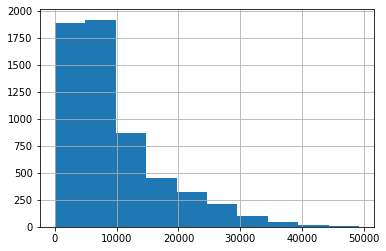

In [408]:
pl = without_moskow["The number of applications for consumer loans"]
pl.hist()

In [415]:
"""
 1   0 - 4000 min
 2   4001 - 8000
 3   8001 - 12000
 4   12001 - 16000
 5   16001 - 20000
 6   20001 - 24
 7   24001 - 28
 8   28001 - 32
 9   32001 - 36
 10   36001 >"""
    

'\n 1   0 - 4000 min\n 2   4000 - 8000\n 3   8000 - 12000\n 4   12000 - 16000\n 5   16000 - 20000\n 6   20 - 24\n 7   24 - 28\n 8   28 - 32\n 9   32 - 36\n 10   36 >'

In [18]:
without_moskow["range"] = without_moskow["The number of applications for consumer loans"] // 4000

In [16]:
without_moskow = without_moskow[without_moskow["region"] != "Russia"]

In [26]:
#эксперимент с ранжированием
without_moskow[(without_moskow["range"] >= 4) & (without_moskow["range"] < 7)] = 4
without_moskow["range"][without_moskow["range"] >= 7] = 5

/home/tanya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
X = without_moskow.drop(["The number of applications for consumer loans", "region", "date", "index", "range"], axis=1)
y = without_moskow["range"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
clf = RandomForestClassifier()

In [600]:
parameters = {'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [1, 3, 5, 7, 9, 11], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], 'min_samples_split': [2, 4, 6, 8]}

In [601]:
#тут забыла cv! Ниже верный вариант
grid_search = GridSearchCV(clf, parameters)

In [40]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [50, 60, 70, 80]})

In [41]:
grid_search.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 70}

In [42]:
best_tree = grid_search.best_estimator_

In [43]:
feature_importances = best_tree.feature_importances_

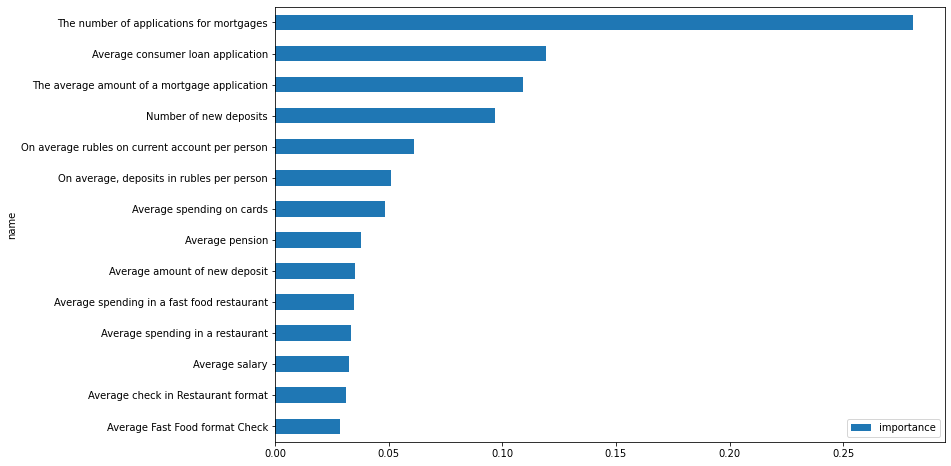

In [44]:
imp = pd.DataFrame(feature_importances, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [45]:
best_tree.score(X_test, y_test)

0.7811203319502075

In [30]:
parameters = {'n_estimators': [50, 60, 70, 80], 'max_depth': [10, 20, 30], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], 'min_samples_split': [2, 4, 6, 8]}

In [31]:
grid_search = GridSearchCV(clf, parameters, cv=3)

In [32]:
grid_search.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [646]:
grid_search.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 80}

In [640]:
best_tree = grid_search.best_estimator_

In [641]:
feature_importances = best_tree.feature_importances_

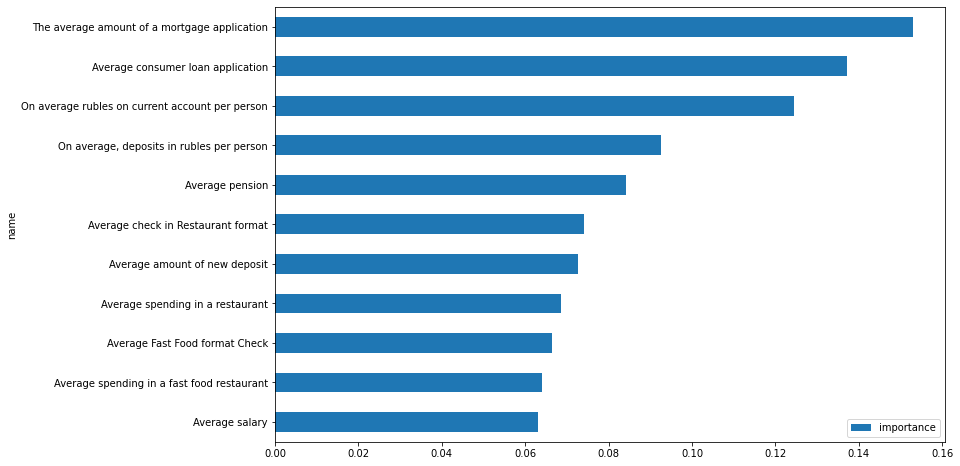

In [642]:
imp = pd.DataFrame(feature_importances, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [645]:
best_tree.score(X_test, y_test)

0.5575726141078838

In [ ]:
#исключим линейно зависимые переменные

In [619]:
X = without_moskow.drop(["The number of applications for consumer loans", "Number of new deposits", "The number of applications for mortgages", "Average spending on cards", "region", "date", "range"], axis=1)
y = without_moskow["range"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [617]:
grid_search = GridSearchCV(clf, parameters, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [50]})

In [621]:
best_tree = grid_search.best_estimator_

In [622]:
best_tree.score(X_test, y_test)

0.4948132780082988

In [ ]:
#напрямую в лес!&!&&!&?????

In [628]:
rf = RandomForestClassifier(100, max_depth=11, min_samples_leaf=1, min_samples_split=4)

In [629]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, min_samples_split=4)

In [630]:
rf.score(X_test, y_test)

0.5020746887966805

In [ ]:
parameters = {'n_estimators': [50, 60, 70, 80], 'max_depth': [10, 20, 30], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], 'min_samples_split': [2, 4, 6, 8]}

In [672]:
X = without_moskow.drop(["The number of applications for consumer loans", "region", "date", "range"], axis=1)
y = without_moskow["range"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [686]:
clf = RandomForestClassifier(200, max_depth=10, min_samples_leaf=5, min_samples_split=4)

In [687]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=4,
                       n_estimators=200)

In [688]:
clf.score(X_test, y_test)

0.6343360995850622

In [18]:
without_moskow = without_moskow.drop("index", axis=1)

In [19]:
k = {}
for nval in without_moskow:
    for value in without_moskow[nval]:
        if(value == 0):
            nval = nval.replace(" ", "")
            k[nval] = 1 if nval not in k else k[nval] + 1
print(k)

{'AverageFastFoodformatCheck': 2106, 'Averageamountofnewdeposit': 1134, 'AveragecheckinRestaurantformat': 2106, 'Averagepension': 972, 'Averagesalary': 1944, 'Averagespendinginafastfoodrestaurant': 2106, 'Averagespendinginarestaurant': 2106, 'Averagespendingoncards': 972, 'Numberofnewdeposits': 1134, 'Onaveragerublesoncurrentaccountperperson': 972, 'Onaverage,depositsinrublesperperson': 972, 'Theaverageamountofamortgageapplication': 1, 'Thenumberofapplicationsformortgages': 1}


In [22]:
X = without_moskow.drop(["The number of applications for consumer loans", "region", "date", "Average Fast Food format Check", "Average check in Restaurant format", "Average spending in a fast food restaurant", "Average spending in a restaurant"], axis=1)
y = without_moskow["The number of applications for consumer loans"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
clf = RandomForestClassifier(50, max_depth=20, min_samples_leaf=1, min_samples_split=2)

In [23]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=50)

In [26]:
clf.feature_importances_

array([0.09049752, 0.13660318, 0.08847026, 0.07109797, 0.08531389,
       0.08707088, 0.08917423, 0.09037624, 0.12941325, 0.13198257])

In [28]:
feature_importances = clf.feature_importances_

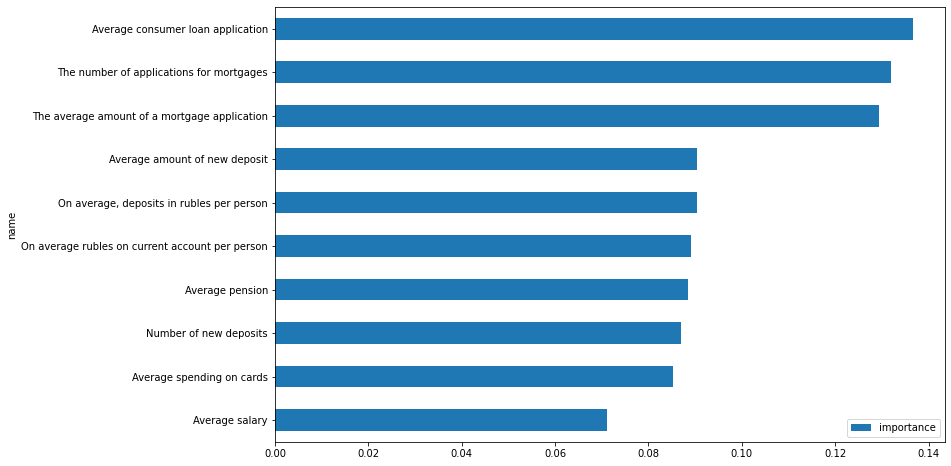

In [29]:
imp = pd.DataFrame(feature_importances, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [ ]:
print('hello')